d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


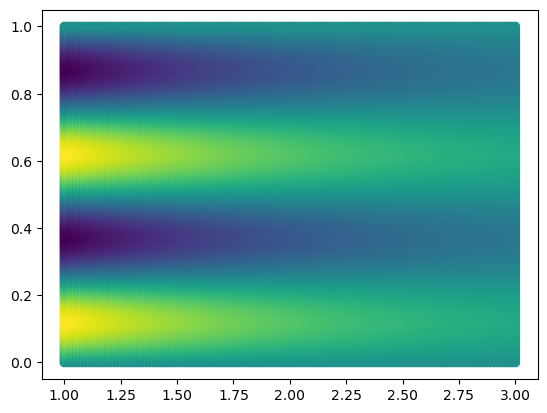

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch
np.random.seed(1)
torch.manual_seed(1)

import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad
from user_funn.geom import line_linspace

# define question
n = 4
a = 0.005
L = 1
tmax = 3

# get ana-solution
import heat_benchmark 
bm = heat_benchmark.HeatBenchMark(n,a,L,tmax)
X,y_true = bm.gen_testdata()
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = y_true)


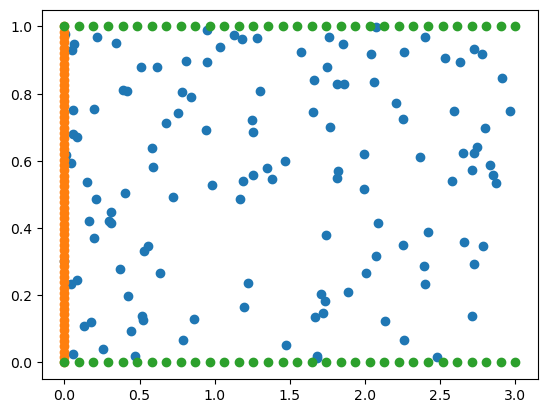

In [2]:
# 保证迭代参数与DEEPXDE一致

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

t_length = tmax

## define a pde
pde_epoch_size = 128
pde_input = D2Field([0,t_length],[0,L]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)

    # 数据提取
    t = x_in[:,[0]]
    x = x_in[:,[1]]
    u = U[:,[0]]

    # 计算一阶导
    dudi = grad(u, x_in)[0]
    dudt = dudi[:,[0]]
    dudx = dudi[:,[1]]
    # 计算二阶导
    du2dxi = grad(dudx, x_in)[0]
    du2dx2 = du2dxi[:,[1]]

    loss = dudt - a * du2dx2
    loss = loss_fn(loss, y_real)
    return loss

## boss tc and bc
from user_funn.bc import data_loss_factory

## define a tc
tc_epoch_size = 64
tc_input = line_linspace([0,0],[0,L],tc_epoch_size)
tc_t = tc_input[:,0]
tc_x = tc_input[:,1]
tc_output = np.sin(n * np.pi * tc_x / L).reshape(tc_epoch_size,1)
tc_loss = data_loss_factory(loss_fn,[0])

## define a bc
bc_epoch_size = 64
bc_input1 = line_linspace([0,0],[tmax,0],bc_epoch_size//2)
bc_input2 = line_linspace([0,L],[tmax,L],bc_epoch_size//2)
bc_input = np.vstack([bc_input1,bc_input2])
bc_output = np.zeros([bc_epoch_size ,1])
bc_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[tc_input,tc_output],[bc_input, bc_output]],
    [pde_loss,tc_loss,bc_loss],
    model = [2, 50, 50, 50, 1],
    optimizer = "adam",
    batchsize = [pde_epoch_size, tc_epoch_size, bc_epoch_size])

import user_funn.plot
user_funn.plot.scatter_2d_cloud_point_kind([pde_input,tc_input,bc_input])


In [3]:
epoch_num = 6000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

loss is [0.00056514 0.47944796 0.0019241  0.4819372 ]
loss is [0.00630886 0.43460774 0.01071323 0.45162982]
loss is [0.00691909 0.43403685 0.0102753  0.45123124]
loss is [0.00703887 0.43379587 0.01030242 0.45113716]
loss is [0.00711638 0.43321854 0.01031676 0.45065168]
loss is [0.00786054 0.43004727 0.01095236 0.44886017]
loss is [0.02849614 0.13980106 0.01556296 0.18386017]
loss is [0.01139814 0.01167338 0.0035433  0.02661483]
loss is [0.00663984 0.00604927 0.00127385 0.01396295]
loss is [0.00428151 0.0041854  0.00074959 0.0092165 ]
loss is [0.00317589 0.00334449 0.00045872 0.00697911]
loss is [0.00254767 0.0031272  0.00055778 0.00623265]
loss is [0.0022027  0.00258436 0.0002822  0.00506926]
loss is [0.00193668 0.00231668 0.00024162 0.00449498]
loss is [0.00176107 0.00230008 0.00050952 0.00457066]
loss is [0.00159836 0.00193871 0.00020667 0.00374374]
loss is [0.00148077 0.00185494 0.00023455 0.00357025]
loss is [0.00137818 0.00165235 0.00018489 0.00321542]
loss is [0.00130782 0.002004

error 0.03844655198074451


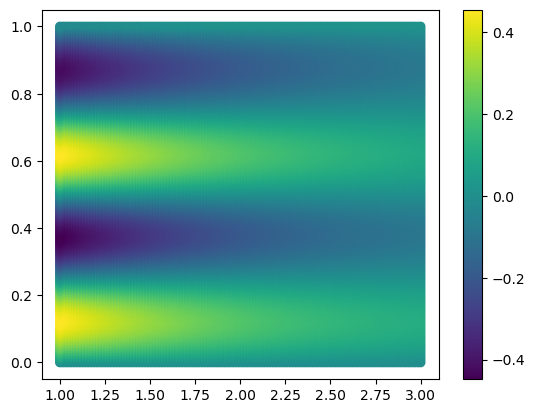

In [4]:
x_cpu,y_real = bm.gen_testdata()
y_cpu = solver.model_eval(x_cpu, use_best_model_flag=False)
plt.scatter(x_cpu[:,0],x_cpu[:,1],c = y_cpu)
print('error',np.abs(y_real-y_cpu).std()/y_real.std())
plt.colorbar()